# Advanced Profile Creation
Creates profiles from parallel lines created in `parallel_transit_lines-Dev` notebook and a digital elevation model. Extends the profile creation from `basic_profile_creation-Dev` to include the transportation route and the location of the NHD streamline.

Assumes transportation routes, from the National Transportation Dataset, align well with elevation data, from the Best Available Topographic dataset.

### Author
John Wall (jwall@Dewberry.com)

### Import libraries

In [1]:
import pandas as pd
import geopandas as gpd

import shapely
from shapely import geometry, ops
from shapely.geometry import Point

import rasterio
from rasterio.plot import show

from matplotlib import pyplot as plt

from rasterstats import zonal_stats, point_query

### Load data

In [2]:
streams = "/mnt/c/gis/fcast_data/sample_streams.shp"
roads = "/mnt/c/gis/fcast_data/sample_roads.shp"
dem = "/mnt/c/gis/fcast_data/tiffs/c67567_aoi.tif"

### Create parallel lines from transportation routes

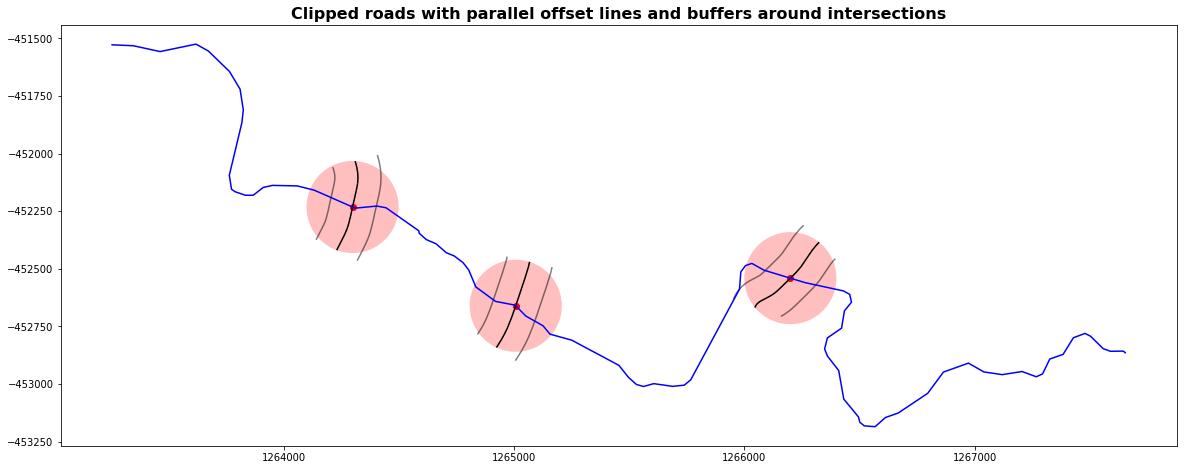

In [49]:
gdf_streams = gpd.read_file(streams)
gdf_roads = gpd.read_file(roads)

stream_prj = gdf_streams.to_crs(gdf_roads.crs)
stream_shape = list(stream_prj.geometry)[0]
gdf_roads_diss = gdf_roads.dissolve(by='FULL_STREE')

intersecting_roads = gdf_roads_diss[gdf_roads_diss.geometry.apply(lambda row: stream_shape.intersects(row))].copy()
intersections = intersecting_roads.geometry.apply(lambda row: stream_shape.intersection(row))
intersection_buffers = intersections.buffer(200)

clipped_roads = intersection_buffers.intersection(intersecting_roads)

single_lines = {}
for i, road in enumerate(clipped_roads):
    if type(road) is shapely.geometry.multilinestring.MultiLineString:
        single_lines[clipped_roads.index[i]] = ops.linemerge(road)
    else:
        single_lines[clipped_roads.index[i]] = road

offset_lines = {}
for street, line in single_lines.items():
    for side in ['left', 'right']:
        key_name = '_'.join([street, side])
        offset_lines[key_name] = line.parallel_offset(100, side, resolution=1)
        
gdf_roads = gpd.GeoDataFrame(offset_lines.items(), columns=['streets','geometry'])

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines and buffers around intersections", fontsize=16, fontweight='bold');

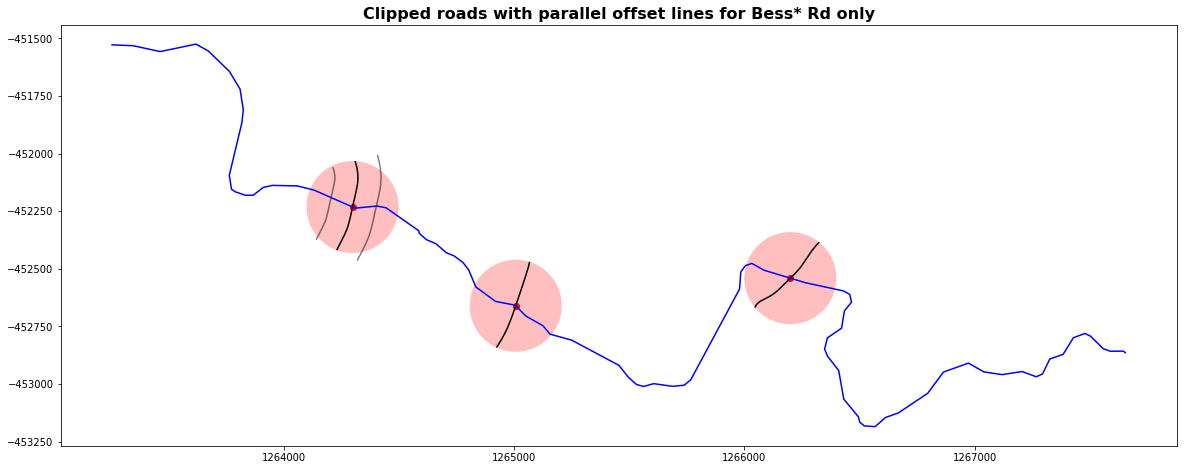

In [63]:
# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
gdf_roads[gdf_roads['streets'].str.contains('Bess')].plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines for Bess* Rd only", fontsize=16, fontweight='bold');

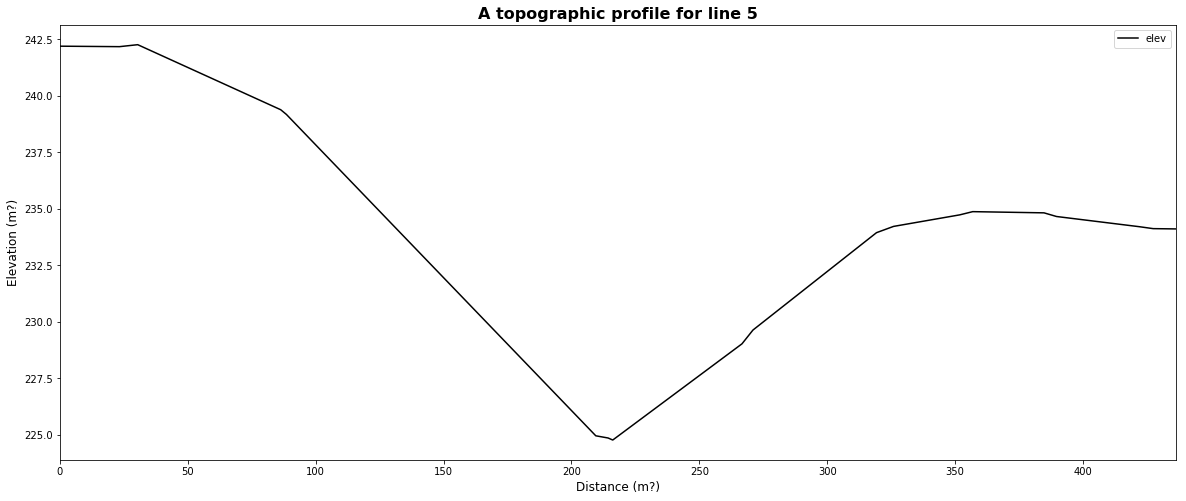

In [67]:
# Create a topographic profile
line_number = 5
profile = point_query(gdf_roads.geometry[line_number], dem)

vertecies = [Point(coord) for coord in gdf_roads.geometry[line_number].coords]
df = pd.DataFrame(vertecies, columns=['point'])
df['elev'] = profile[0]
df['distance'] = [df.point[0].distance(df.point[i]) for i in range(len(df))]

fig, ax = plt.subplots(figsize = (20,8))
df.plot(x='distance',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Distance (m?)", fontsize=12)
ax.set_title("A topographic profile for line {}".format(line_number), fontsize=16, fontweight='bold');

In [90]:
# Define a function from the above
def multi_to_single_lines(input_lines:list) -> dict:
    """Ensures all lines are single part linestrings."""
    single_lines = {}
    for i, line in enumerate(input_lines):
        if type(line) is shapely.geometry.multilinestring.MultiLineString:
            single_lines[input_lines.index[i]] = ops.linemerge(line)
        else:
            single_lines[input_lines.index[i]] = line
    
    return single_lines

In [92]:
# I can't be bothered to remember the full name of this road
rough_name = 'Bess'

# Threshold out this line from the roads
sing_line_dict = multi_to_single_lines(clipped_roads[clipped_roads.index.str.contains(rough_name)])

In [104]:
# Define another function
def get_topo_profile(line_dict:dict, dem:str) -> pd.core.frame.DataFrame:
    line = list(line_dict.values())[0]
    profile = point_query(line, dem)

    vertecies = [Point(coord) for coord in line.coords]
    df = pd.DataFrame(vertecies, columns=['point'])
    df['elev'] = profile[0]
    df['distance'] = [df.point[0].distance(df.point[i]) for i in range(len(df))]
    
    return df

In [106]:
road_profile = get_topo_profile(sing_line_dict, dem)

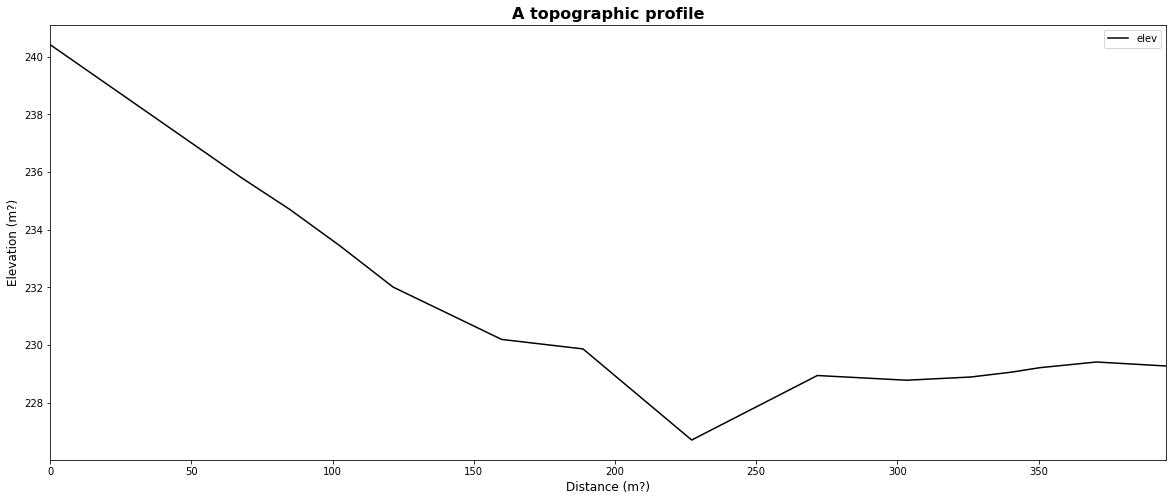

In [109]:
fig, ax = plt.subplots(figsize = (20,8))
road_profile.plot(x='distance',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Distance (m?)", fontsize=12)
ax.set_title("A topographic profile", fontsize=16, fontweight='bold');

In [124]:
sample_dict = gdf_roads[gdf_roads['streets'].str.contains('Bess')].loc[0]

In [127]:
def get_topo_profile_df(line_dict, dem:str) -> pd.core.frame.DataFrame:
    line = sample_dict.geometry
    profile = point_query(line, dem)

    vertecies = [Point(coord) for coord in line.coords]
    df = pd.DataFrame(vertecies, columns=['point'])
    df['elev'] = profile[0]
    df['distance'] = [df.point[0].distance(df.point[i]) for i in range(len(df))]
    
    return df

In [128]:
profile = get_topo_profile_df(sample_dict, dem)

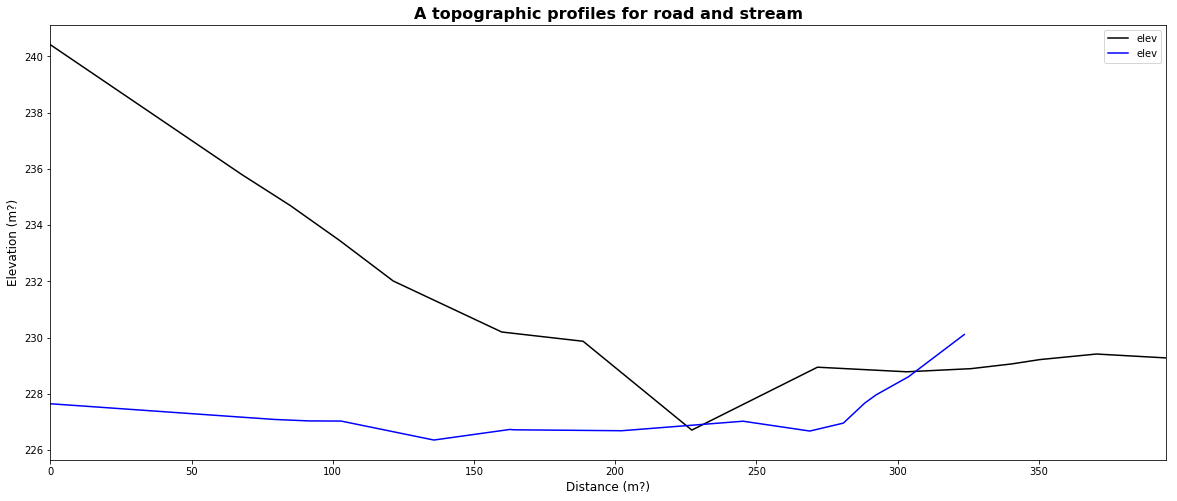

In [133]:
# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
road_profile.plot(x='distance',y='elev', color='k', ax=ax);
profile.plot(x='distance',y='elev', color='b', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Distance (m?)", fontsize=12)
ax.set_title("A topographic profiles for road and stream", fontsize=16, fontweight='bold');